In [1]:
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import seaborn as sns;
from sklearn.linear_model import LogisticRegression;
from sklearn.preprocessing import LabelEncoder;
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

In [2]:
%matplotlib inline

In [3]:
training_set = pd.read_csv('FootballTrainDataSet.csv')
test_set = pd.read_csv('FootballTestDataSet.csv')

In [4]:
list(training_set)

['ID',
 'Date',
 'Opponent',
 'Is_Home_or_Away',
 'Is_Opponent_in_AP25_Preseason',
 'Media',
 'Label']

In [5]:
training_set.head()

,ID,Date,Opponent,Is_Home_or_Away,Is_Opponent_in_AP25_Preseason,Media,Label
0,1,9/5/2015,Texas,Home,Out,1-NBC,Win
1,2,9/12/2015,Virginia,Away,Out,4-ABC,Win
2,3,9/19/2015,GeorgiaTech,Home,In,1-NBC,Win
3,4,9/26/2015,UMass,Home,Out,1-NBC,Win
4,5,10/3/2015,Clemson,Away,In,4-ABC,Lose


## Performing Data Preprocessing

In [6]:
training_set.isnull().sum()

ID                               0
Date                             0
Opponent                         0
Is_Home_or_Away                  0
Is_Opponent_in_AP25_Preseason    0
Media                            0
Label                            0
dtype: int64

In [7]:
test_set.isnull().sum()

ID                               0
Date                             0
Opponent                         0
Is_Home_or_Away                  0
Is_Opponent_in_AP25_Preseason    0
Media                            0
Label                            0
dtype: int64

In [8]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   ID                             24 non-null     int64 
 1   Date                           24 non-null     object
 2   Opponent                       24 non-null     object
 3   Is_Home_or_Away                24 non-null     object
 4   Is_Opponent_in_AP25_Preseason  24 non-null     object
 5   Media                          24 non-null     object
 6   Label                          24 non-null     object
dtypes: int64(1), object(6)
memory usage: 1.4+ KB


In [9]:
training_set.describe(include=[np.object])

,Date,Opponent,Is_Home_or_Away,Is_Opponent_in_AP25_Preseason,Media,Label
count,24,24,24,24,24,24
unique,24,20,2,2,5,2
top,9/4/2016,Texas,Home,Out,1-NBC,Win
freq,1,2,15,17,14,14


In [10]:
combine = [training_set, test_set]

In [11]:
Opponent_mapping = {"Texas": 1, "Virginia": 2, "GeorgiaTech": 3, "UMass": 4, "Clemson": 5, 
                    "Navy": 6, "USC": 7, "Temple": 8, "PITT": 9, "WakeForest": 10, 
                    "BostonCollege": 11, "Stanford": 12, "Nevada": 13, "MichiganState": 14, "Duke": 15, 
                    "Syracuse": 16, "NorthCarolinaState": 17, "MiamiFlorida": 18, "Army": 19, "VirginiaTech": 20,
                    "MiamiOhio": 21, "NorthCarolina": 22, "Georgia": 23
}

le = LabelEncoder();
for dataset in combine:
    dataset['Opponent'] = dataset['Opponent'].map(Opponent_mapping)
    dataset['Is_Home_or_Away'] = le.fit_transform(dataset['Is_Home_or_Away'])
    dataset['Is_Opponent_in_AP25_Preseason'] = le.fit_transform(dataset['Is_Opponent_in_AP25_Preseason'])
    dataset['Media'] = dataset['Media'].str.extract('(\d+)').astype(int)
    dataset['Label'] = le.fit_transform(dataset['Label'])

In [12]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   ID                             24 non-null     int64 
 1   Date                           24 non-null     object
 2   Opponent                       24 non-null     int64 
 3   Is_Home_or_Away                24 non-null     int32 
 4   Is_Opponent_in_AP25_Preseason  24 non-null     int32 
 5   Media                          24 non-null     int32 
 6   Label                          24 non-null     int32 
dtypes: int32(4), int64(2), object(1)
memory usage: 1.1+ KB


In [13]:
training_set.head()

,ID,Date,Opponent,Is_Home_or_Away,Is_Opponent_in_AP25_Preseason,Media,Label
0,1,9/5/2015,1,1,1,1,1
1,2,9/12/2015,2,0,1,4,1
2,3,9/19/2015,3,1,0,1,1
3,4,9/26/2015,4,1,1,1,1
4,5,10/3/2015,5,0,0,4,0


In [14]:
test_set.head()

,ID,Date,Opponent,Is_Home_or_Away,Is_Opponent_in_AP25_Preseason,Media,Label
0,25,9/2/2017,8,1,1,1,1
1,26,9/9/2017,23,1,0,1,0
2,27,9/16/2017,11,0,1,2,1
3,28,9/23/2017,14,0,1,3,1
4,29,9/30/2017,21,1,1,1,1


In [15]:
training_set[['Is_Opponent_in_AP25_Preseason',
              'Label']].groupby(by =['Is_Opponent_in_AP25_Preseason'], 
                                                                as_index=False).mean().sort_values(by=['Label'], 
                                                                                                   ascending=False)

,Is_Opponent_in_AP25_Preseason,Label
1,1,0.705882
0,0,0.285714


In [16]:
training_set[['Media','Label']].groupby(by =['Media'], 
                                                  as_index=False).mean().sort_values(by=['Label'], ascending=False)

,Media,Label
1,2,1.000000
0,1,0.714286
3,4,0.428571
2,3,0.000000
4,5,0.000000


In [17]:
training_set[['Is_Home_or_Away','Label']].groupby(by =['Is_Home_or_Away'], 
                                                  as_index=False).mean().sort_values(by=['Label'], ascending=False)

,Is_Home_or_Away,Label
1,1,0.666667
0,0,0.444444


In [18]:
training_set[['Opponent','Label']].groupby(by =['Opponent'], 
                                                  as_index=False).mean().sort_values(by=['Label'], ascending=False)

,Opponent,Label
10,11,1.0
12,13,1.0
2,3,1.0
3,4,1.0
18,19,1.0
17,18,1.0
15,16,1.0
7,8,1.0
8,9,1.0
9,10,1.0


In [19]:
Y_train = training_set["Label"]
Y_train.shape

(24,)

In [20]:
training_set = training_set.drop(['ID','Date'], axis=1)
X_train_correlation = training_set
training_set = training_set.drop(['Label'], axis=1)
X_train = training_set

In [21]:
mapper = DataFrameMapper([(X_train.columns, StandardScaler())])
scaled_features = mapper.fit_transform(X_train.copy(), 5)
X_train = pd.DataFrame(scaled_features, index=X_train.index, columns=X_train.columns)

In [22]:
X_train.head()

,Opponent,Is_Home_or_Away,Is_Opponent_in_AP25_Preseason,Media
0,-1.550132,0.774597,0.641689,-0.797724
1,-1.374645,-1.290994,0.641689,1.253566
2,-1.199159,0.774597,-1.558387,-0.797724
3,-1.023672,0.774597,0.641689,-0.797724
4,-0.848185,-1.290994,-1.558387,1.253566


In [23]:
Y_test = test_set["Label"]

In [24]:
test_set = test_set.drop(['ID','Date','Label'], axis=1)
X_test = test_set

In [25]:
mapper = DataFrameMapper([(X_test.columns, StandardScaler())])
scaled_features = mapper.fit_transform(X_test.copy(), 4)
X_test = pd.DataFrame(scaled_features, index=X_test.index, columns=X_test.columns)

In [26]:
X_test.head()

,Opponent,Is_Home_or_Away,Is_Opponent_in_AP25_Preseason,Media
0,-1.057749,0.845154,0.707107,-0.774597
1,1.550399,0.845154,-1.414214,-0.774597
2,-0.536119,-1.183216,0.707107,0.000000
3,-0.014490,-1.183216,0.707107,0.774597
4,1.202646,0.845154,0.707107,-0.774597


In [27]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((24, 4), (24,), (12, 4), (12,))

# Performing Feature Selection

In [28]:
train_new=SelectKBest(score_func=chi2,k='all').fit(training_set,Y_train)
train_new_scores = pd.DataFrame(train_new.scores_)
train_new_columns = pd.DataFrame(training_set.columns)
feature_scores = pd.concat([train_new_columns, train_new_scores],axis=1)
feature_scores.columns = ['Feature_Name','Score']  
print(feature_scores.nlargest(5,'Score')) 

                    Feature_Name     Score
3                          Media  3.173626
0                       Opponent  1.983535
2  Is_Opponent_in_AP25_Preseason  1.050420
1                Is_Home_or_Away  0.428571


#### Top 3 features by using Statistical Method - SelectKBest are: Media, Opponent, Is_Opponent_in_AP25_Preseason

In [29]:
X_train_correlation.corr(method = 'pearson')

,Opponent,Is_Home_or_Away,Is_Opponent_in_AP25_Preseason,Media,Label
Opponent,1.000000,0.249207,0.045579,-0.321643,-0.158201
Is_Home_or_Away,0.249207,1.000000,0.071007,-0.735612,0.218218
Is_Opponent_in_AP25_Preseason,0.045579,0.071007,1.000000,0.010447,0.387376
Media,-0.321643,-0.735612,0.010447,1.000000,-0.365994
Label,-0.158201,0.218218,0.387376,-0.365994,1.000000


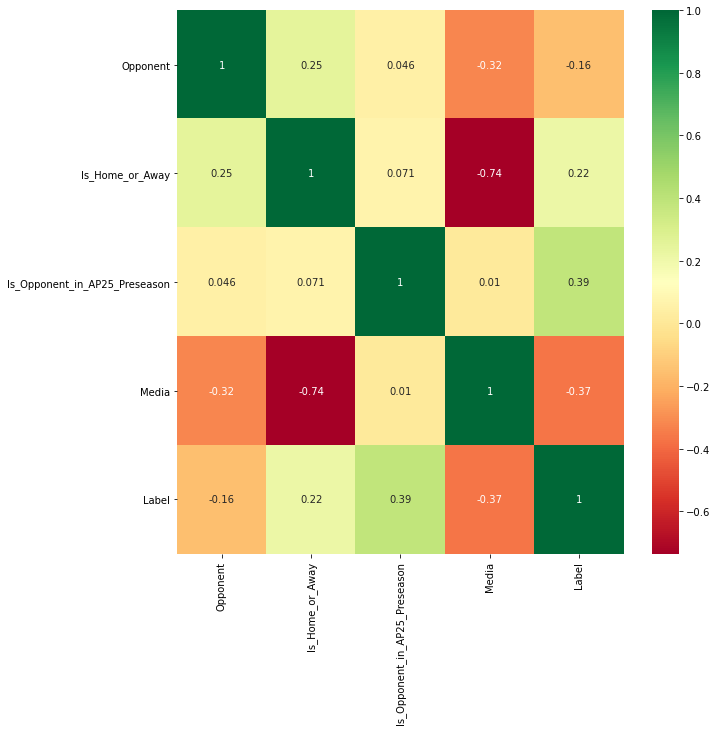

In [30]:
corrmat = X_train_correlation.corr(method = 'pearson')
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))

g=sns.heatmap(X_train_correlation[top_corr_features].corr(),annot=True,cmap="RdYlGn")

#### Top 3 features from Correlation Matrix are: Is_Opponent_in_AP25_Preseason, Media, Is_Home_or_Away

In [31]:
model = LogisticRegression(max_iter=1000)
rfe = RFE(model)
fit = rfe.fit(X_train, Y_train)

print("Feature Ranking: ",fit.ranking_)
print(X_train.head())

Feature Ranking:  [2 3 1 1]
   Opponent  Is_Home_or_Away  Is_Opponent_in_AP25_Preseason     Media
0 -1.550132         0.774597                       0.641689 -0.797724
1 -1.374645        -1.290994                       0.641689  1.253566
2 -1.199159         0.774597                      -1.558387 -0.797724
3 -1.023672         0.774597                       0.641689 -0.797724
4 -0.848185        -1.290994                      -1.558387  1.253566


#### Top 3 features from RFE are: Is_Opponent_in_AP25_Preseason, Media, Opponent

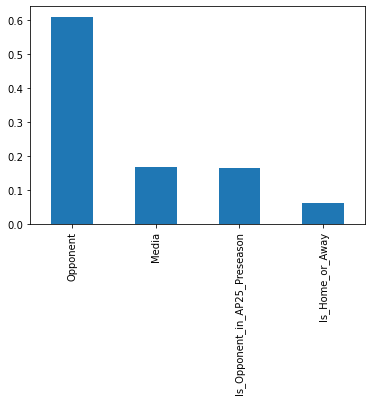

In [32]:
ex = ExtraTreesClassifier()
ex.fit(X_train, Y_train)

feat_importances = pd.Series(ex.feature_importances_, index=X_train.columns)
feat_importances.nlargest(4).plot(kind='bar')
plt.show()

#### Top 3 features from ExtrasTreesClassifier are: Opponent, Is_Opponent_in_AP25_Preseason, Media

#### Final variable that are considered to train the model is  Is_Opponent_in_AP25_Preseason, Media,  Opponent

In [33]:
def trainAndPredict(model):
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    mismatch = 0
    for estimate, real in zip(predictions, Y_test):
        if estimate != real:
            mismatch += 1
    return mismatch

In [34]:
X_train.head()

,Opponent,Is_Home_or_Away,Is_Opponent_in_AP25_Preseason,Media
0,-1.550132,0.774597,0.641689,-0.797724
1,-1.374645,-1.290994,0.641689,1.253566
2,-1.199159,0.774597,-1.558387,-0.797724
3,-1.023672,0.774597,0.641689,-0.797724
4,-0.848185,-1.290994,-1.558387,1.253566


In [35]:
X_train = X_train.drop(['Is_Home_or_Away'], axis=1)
X_test  = X_test.drop(['Is_Home_or_Away'], axis=1)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((24, 3), (24,), (12, 3), (12,))

## Using Naive Bayes

In [36]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
conf_matrix = confusion_matrix(Y_test, Y_pred)

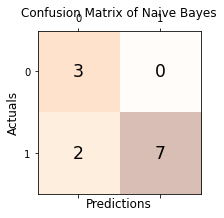

In [37]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix of Naive Bayes', fontsize=12)
plt.show()

In [38]:
tn, fp, fn, tp = confusion_matrix([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0], [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0]).ravel()
print('True Positive: %d' % tp)
print('False Positive: %d' % fp)
print('True Negative: %d' % tn)
print('False Negative: %d' % fn)

True Positive: 7
False Positive: 0
True Negative: 3
False Negative: 2


###  Naive Bayes: The Accuracy, Precision, Recall, and F1 score on the testing result

In [39]:
print('Accuracy Score: %.3f' % accuracy_score(Y_test, Y_pred))
print('Precision Score: %.3f' % precision_score(Y_test, Y_pred))
print('Recall Score: %.3f' % recall_score(Y_test, Y_pred))
print('F1 Score: %.3f' % f1_score(Y_test, Y_pred))

Accuracy Score: 0.833
Precision Score: 1.000
Recall Score: 0.778
F1 Score: 0.875


### Naive Bayes: The prediction labels of the 12 testing games 

In [40]:
print(Y_pred)

[1 0 1 1 1 0 0 1 1 0 1 0]


In [41]:
print(f"Out of {len(X_test)} records, the Gaussian Naive Bayes classifier has {trainAndPredict(gaussian)} incorrect predictions")

Out of 12 records, the Gaussian Naive Bayes classifier has 2 incorrect predictions


## Using KNN

In [42]:
k_range=range(1,24)
scores=[]
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    Y_predKNN = knn.predict(X_test)
    scores.append(accuracy_score(Y_test,Y_predKNN))
print(scores)

[0.9166666666666666, 0.75, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.75, 0.75, 0.75]


Text(0, 0.5, 'Testing accuracy')

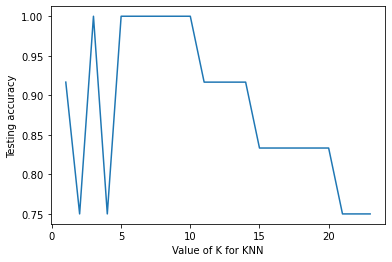

In [43]:
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing accuracy')

### K value we can consider 3 as it has the highest accuracy rate.

In [44]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_predKNN = knn.predict(X_test)
cm = confusion_matrix(Y_test, Y_predKNN)

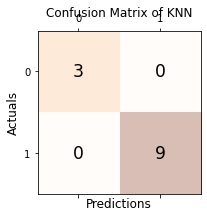

In [45]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix of KNN', fontsize=12)
plt.show()

In [46]:
tn, fp, fn, tp = confusion_matrix([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0], [1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]).ravel()
print('True Positive: %d' % tp)
print('False Positive: %d' % fp)
print('True Negative: %d' % tn)
print('False Negative: %d' % fn)

True Positive: 9
False Positive: 0
True Negative: 3
False Negative: 0


###  KNN: The Accuracy, Precision, Recall, and F1 score on the testing result

In [47]:
print('Accuracy Score: %.3f' % accuracy_score(Y_test, Y_predKNN))
print('Precision Score: %.3f' % precision_score(Y_test, Y_predKNN))
print('Recall Score: %.3f' % recall_score(Y_test, Y_predKNN))
print('F1 Score: %.3f' % f1_score(Y_test, Y_predKNN))


Accuracy Score: 1.000
Precision Score: 1.000
Recall Score: 1.000
F1 Score: 1.000


### KNN: The prediction labels of the 12 testing games 

In [48]:
print(Y_predKNN)

[1 0 1 1 1 1 1 1 1 0 1 0]


In [49]:
print(f"Out of {len(X_test)} records, the Gaussian Naive Bayes classifier has {trainAndPredict(knn)} incorrect predictions")

Out of 12 records, the Gaussian Naive Bayes classifier has 0 incorrect predictions
